In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import gzip
import json
import zstd
import polars as pl
import time

# No. of Videos Commented Daily by Each Author

### videos_commented_daily.parquet dataset:
It contains authors that commented on at least 10 videos on a specific day
- author: user id
- videos_comments: no. of videos commented on the day
- upload_date: date of the day

In [2]:
%%time
# Read dataset parquet using polars (much faster!)
authors_df = pl.read_parquet("author_comments_per_video_2018.parquet", low_memory=True, columns=["author","upload_date"])

CPU times: user 5.15 s, sys: 12.9 s, total: 18.1 s
Wall time: 1.39 s


In [30]:
%%time
# Get video commented on per day anf filter authros that comment on many vidoes on a single day
import polars as pl
from datetime import datetime, timedelta

# Initialize list to store daily results
daily_results = []

# Start date (min date in authors_df) and end date (max date in authors_df)
start_date = authors_df.select(pl.col("upload_date").min())[0, 0]
end_date = authors_df.select(pl.col("upload_date").max())[0, 0]

# Loop over each day until the end date
current_date = start_date
while current_date <= end_date:
    print(f"\n\ncurrent_date:{current_date}\t(end:{end_date})")
    # Filter the DataFrame for the current day
    daily_df = authors_df.filter(pl.col("upload_date") == current_date)
    
    # Group by "author" and count videos for each author on the current day
    result = (
        daily_df.lazy()
        .group_by("author")
        .agg(pl.count().alias("videos_commented"))
        .filter(pl.col("videos_commented") >= 10)  # Keep only authors with at least 10 videos commented
        .with_columns(pl.lit(current_date).alias("upload_date"))  # Add the upload_date column
        .collect(streaming=True)
    )
    
    print(len(result))
    
    # Append the result to the list if it has data
    if not result.is_empty():
        daily_results.append(result)
    
    # Move to the next day
    current_date += timedelta(days=1)




current_date:2018-01-01	(end:2018-12-31)


<timed exec>:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


548


current_date:2018-01-02	(end:2018-12-31)
973


current_date:2018-01-03	(end:2018-12-31)
1052


current_date:2018-01-04	(end:2018-12-31)
1144


current_date:2018-01-05	(end:2018-12-31)
1130


current_date:2018-01-06	(end:2018-12-31)
637


current_date:2018-01-07	(end:2018-12-31)
690


current_date:2018-01-08	(end:2018-12-31)
1240


current_date:2018-01-09	(end:2018-12-31)
1101


current_date:2018-01-10	(end:2018-12-31)
1213


current_date:2018-01-11	(end:2018-12-31)
1584


current_date:2018-01-12	(end:2018-12-31)
1538


current_date:2018-01-13	(end:2018-12-31)
806


current_date:2018-01-14	(end:2018-12-31)
748


current_date:2018-01-15	(end:2018-12-31)
996


current_date:2018-01-16	(end:2018-12-31)
1303


current_date:2018-01-17	(end:2018-12-31)
1409


current_date:2018-01-18	(end:2018-12-31)
1373


current_date:2018-01-19	(end:2018-12-31)
1325


current_date:2018-01-20	(end:2018-12-31)
920


current_date:2018-01-21	(end:2018-12-31)
648


current_date:2018-01-22	(end:2018-12-31)
1

In [31]:
%%time
# Concatenate all daily results into a single DataFrame
all_daily_results = pl.concat(daily_results)
all_daily_results = all_daily_results.sort(["author","upload_date"])
all_daily_results


CPU times: user 187 ms, sys: 14.4 ms, total: 202 ms
Wall time: 39.5 ms


author,videos_commented,upload_date
i64,u32,date
1695,10,2018-04-21
1695,10,2018-04-28
1695,10,2018-05-12
1695,10,2018-05-15
1695,11,2018-05-17
…,…,…
576531454,11,2018-12-17
576531454,10,2018-12-18
576531454,11,2018-12-20


In [32]:
all_daily_results["videos_commented"].describe()

statistic,value
str,f64
"""count""",707661.0
"""null_count""",0.0
"""mean""",12.91721
"""std""",4.517499
"""min""",10.0
"""25%""",10.0
"""50%""",11.0
"""75%""",14.0
"""max""",149.0


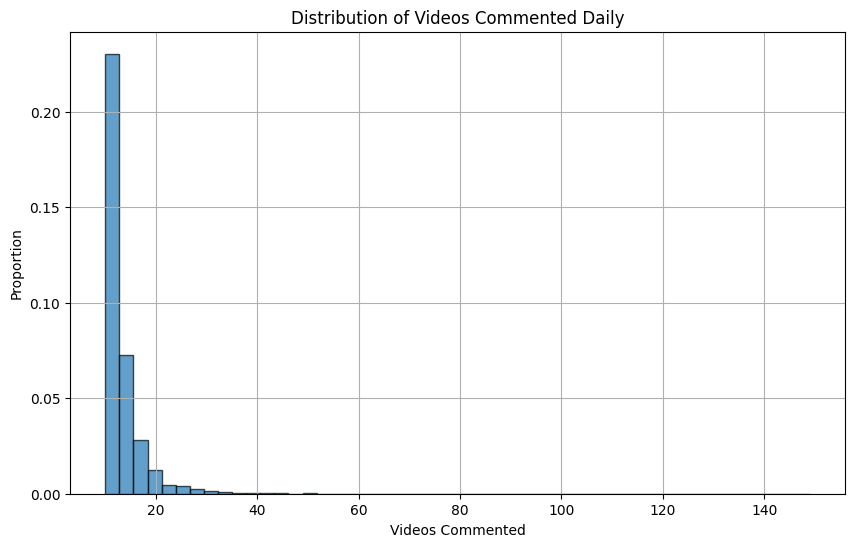

In [33]:
import matplotlib.pyplot as plt

# Plot the distribution of "videos_commented"
plt.figure(figsize=(10, 6))
plt.hist(all_daily_results["videos_commented"].to_list(), bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Distribution of Videos Commented Daily')
plt.xlabel('Videos Commented')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()


In [34]:
# Count the unique authors in the DataFrame
unique_authors_count = all_daily_results["author"].n_unique()

# Print the count of unique authors
print(f"Number of unique authors: {unique_authors_count}")


Number of unique authors: 119906


In [35]:
all_daily_results.write_parquet("videos_commented_daily.parquet", compression='zstd')